In [131]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import time
#Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

In [45]:
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

## Retrieving Data

In [46]:
#Read csv
train = pd.read_csv (r'train.csv')
test = pd.read_csv (r'test.csv')

In [47]:
df_train = pd.DataFrame(train, columns= ['id','raw_address','POI/street'])
print(df_train)

            id                                        raw_address  \
0            0  jl kapuk timur delta sili iii lippo cika 11 a ...   
1            1                                 aye, jati sampurna   
2            2               setu siung 119 rt 5 1 13880 cipayung   
3            3                               toko dita, kertosono   
4            4                                      jl. orde baru   
...        ...                                                ...   
299995  299995               jend ahmad yani 331 kertasari ciamis   
299996  299996                 raya cila kko, cilandak timur kel.   
299997  299997                     tanjung gusta jl. yaya 2 no 17   
299998  299998  jalan cipadu jaya taman asri gang bijaksana 3 ...   
299999  299999          jaya maspion permata blok beryl b2  no.58   

                                       POI/street  
0       /jl kapuk timur delta sili iii lippo cika  
1                                               /  
2              

In [48]:
df_test = pd.DataFrame(test, columns= ['id','raw_address'])
print(df_test)

          id                                        raw_address
0          0              s. par 53 sidanegara 4 cilacap tengah
1          1              angg per, baloi indah kel. lubuk baja
2          2                              asma laun, mand imog,
3          3      ud agung rej, raya nga sri wedari karanganyar
4          4                         cut mutia, 35 baiturrahman
...      ...                                                ...
49995  49995                    toko mbak farid semboro semboro
49996  49996     vie - tk. ridho kids, vete 3 cari, 16720 ciawi
49997  49997                mart dan roti bakar malabar, nasio,
49998  49998  graha indah pamulang jl. mujair raya bambu apu...
49999  49999                                               adi,

[50000 rows x 2 columns]


In [49]:
#Call all the raw addresses
df_train.raw_address

0         jl kapuk timur delta sili iii lippo cika 11 a ...
1                                        aye, jati sampurna
2                      setu siung 119 rt 5 1 13880 cipayung
3                                      toko dita, kertosono
4                                             jl. orde baru
                                ...                        
299995                 jend ahmad yani 331 kertasari ciamis
299996                   raya cila kko, cilandak timur kel.
299997                       tanjung gusta jl. yaya 2 no 17
299998    jalan cipadu jaya taman asri gang bijaksana 3 ...
299999            jaya maspion permata blok beryl b2  no.58
Name: raw_address, Length: 300000, dtype: object

In [50]:
#Get a rows of addresses
df_train.loc[2:6]

,id,raw_address,POI/street
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung
3,3,"toko dita, kertosono",toko dita/
4,4,jl. orde baru,/jl. orde baru
5,5,"raya samb gede, 299 toko bb kids",toko bb kids/raya samb gede
6,6,"kem mel raya, no 4 bojong rawalumbu rt 1 36 ra...",/kem mel raya


In [51]:
df_train.raw_address.shape

(300000,)

In [52]:
splitedAddress = df_train['POI/street'].apply(lambda x: x.split('/'))
df_train['POI'] = splitedAddress.apply(lambda x: x[0])
df_train['street'] = splitedAddress.apply(lambda x: x[1])

In [53]:
df_train = pd.DataFrame(df_train, columns= ['id','raw_address','POI','street'])

In [43]:
df_train

,id,raw_address,POI,street
0,0,jl kapuk timur delta sili iii lippo cika 11 a ...,NaN,NaN
1,1,"aye, jati sampurna",NaN,NaN
2,2,setu siung 119 rt 5 1 13880 cipayung,NaN,NaN
3,3,"toko dita, kertosono",NaN,NaN
4,4,jl. orde baru,NaN,NaN
...,...,...,...,...
299995,299995,jend ahmad yani 331 kertasari ciamis,NaN,NaN
299996,299996,"raya cila kko, cilandak timur kel.",NaN,NaN
299997,299997,tanjung gusta jl. yaya 2 no 17,NaN,NaN
299998,299998,jalan cipadu jaya taman asri gang bijaksana 3 ...,NaN,NaN


## Visualization

C:\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


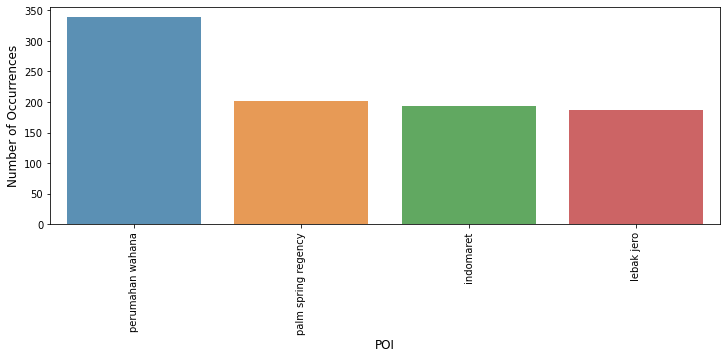

In [139]:
#Display POI
cnt_pro = df_train['POI'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro[1:5].index, cnt_pro[1:5].values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('POI', fontsize=12)
plt.xticks(rotation=90)
plt.show()

## Tokenization

In [143]:
def tokenize(contents):
  allAddresses = contents
  tokens = []
  for address in allAddresses:
    words = address.split()
    for word in words:
      tokens.append(word.lower())
  return tokens

In [144]:
#Get Tokens
trainX_tokens = tokenize(df_train.raw_address)
trainY1_tokens = tokenize(df_train.POI)
trainY2_tokens = tokenize(df_train.street)

In [145]:
#Number of tokens found
print("raw address: ",len(trainX_tokens))
print("POI: ",len(trainY1_tokens))
print("street: ",len(trainY2_tokens))

raw address:  2052655
POI:  343135
street:  514871


In [146]:
# number of UNIQUE tokens found
print("raw address: ",len(set(trainX_tokens)))
print("POI: ",len(set(trainY1_tokens)))
print("street: ",len(set(trainY2_tokens)))

vocabulary = set(trainX_tokens)
vocab_size = len(vocabulary)

raw address:  121318
POI:  53246
street:  23866


In [147]:
frequency_dist = nltk.FreqDist(trainX_tokens)
#Show top 50 tokens
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:5]

['no', 'rt', 'raya', '1', 'rw']

## Set Up the Model

In [148]:
raws = df_train['raw_address']
pois = df_train['POI']

In [164]:
# TOKENIZE TEXT SEQUENCE
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['raw_address'].values)

In [150]:
X = tokenizer.texts_to_sequences(df_train['raw_address'].values)
X = pad_sequences(X)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (300000, 33)


In [151]:
Y = tokenizer.texts_to_sequences(df_train['POI'].values)
Y = pad_sequences(Y)
print('Shape of data tensor:', Y.shape)

Shape of data tensor: (300000, 23)


In [153]:
tokenizer.sequences_to_texts(X)

la tamalate',
 'badan pertan nasional kabupaten jayawi wamena kota wamena',
 'ir suci 31 pasar sayur pagi gg bakar',
 'warung bunda july macc sawah maccini gusung',
 'tanah tinggi asian high 25 117 binjai timur',
 'jl raya ser cikande jayanti',
 'gatot subr cikarang utara',
 'kutisari kuti indah utara x 70 6 tenggilis mejoyo',
 'gd graha matapel jalan arjuna utara no 46 duri kepa',
 'pandean lamper bant utara xi rw 5 gayamsari',
 'teuku umar barat 99 kerobokan kelod kuta utara',
 'bojongherang ir haji djua no 40 43216 cianjur',
 'perumahan wahana cikarang blok f12 no 17 sukadami cikarang selatan',
 'dir i 4 bandung kulon',
 'raya pasar kemis gelam jaya kel',
 'smk bhakti kartini jalan caringin no 8 jembatan 14 bojong menteng',
 'kap cek syeh 183 ilir timur i',
 'rm cak anjun kh agus salim kepek wonosari',
 'hang tuah madras hulu kel',
 'tura barat i no 10 40263 lengkong',
 'soto bu nah bibis kasihan',
 'sug pran upt mojogedang',
 'gg perm i 87 jawa singkawang tengah',
 'mulia elektr ve

In [154]:
print("X: ",X.shape)
print("Y: ",Y.shape)

X:  (300000, 33)
Y:  (300000, 23)


In [163]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
#print(word_index)
print(vocab_size)

81787


In [116]:
print("Raw address: ",raws[5])
print(x[5])
print("POI: ",pois[5])
print(y[5])

Raw address:  raya samb gede, 299 toko bb kids
[list([3, 3221, 128, 7032, 23, 3222, 2181])]
POI:  toko bb kids
[list([23, 3222, 2181])]


In [170]:
#Variables
RANDOM_STATE = 50
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 0
SAVE_MODEL = True
# OUTPUT DIMENSION OF THE EMBEDDING LAYER
EM_OUTPUT_LENGTH = 100

In [118]:
# GET THE SEQUENCE LENGTH
seq_length = x.shape[0]
seq_length

300000

In [177]:
# Fit Model function
def fit_model(batch_size, X, y, epochs):
    model = Sequential()
    model.add(Embedding(vocab_size, EM_OUTPUT_LENGTH))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)

    model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    # save the weights for different configuration
    filepath = f"LSTM-{epochs}_epoch-{batch_size}_batch_size"

    csv_logger = CSVLogger(filepath+".csv",append=False,separator=',')
    checkpoint = ModelCheckpoint(filepath+".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=1, min_lr=1e-8)
    early_stopping = EarlyStopping(monitor='loss',
                                    mode='min',
                                    verbose=1,
                                    patience=5)
    desired_callbacks = [checkpoint, early_stopping, csv_logger, reduce_lr]
    start = time.perf_counter()
    model.fit(X, y, 
              batch_size = batch_size, 
              epochs = epochs, 
              callbacks=desired_callbacks)
    time_taken = time.perf_counter() - start
    print(f"Total time taken for {epochs} epochs: {time_taken} seconds")
    print(f"Average time taken per epochs: {time_taken/epochs} seconds")
    print(f"Total time taken to train: {time_taken} seconds")

    return model

In [178]:
# LOAD PRE-TRAINED H5 FILES
# Write a function to load different variant of the pre-trained model
def load_pretrain_model(model_name,batch_size,epochs, optimizer_type):
    filepath = f"{WEIGHTS_DIR}{model_name}-{epochs}_epoch-{batch_size}_batch_size-{optimizer_type}.h5"
    # debug
    #print(filepath)

    # load the model
    model = load_model(filepath)
    #model.summary()

    return model

In [179]:
model = fit_model(batch_size=BATCH_SIZE, X=X, y=Y, epochs=EPOCHS)

Epoch 1/150


ValueError: in user code:

    C:\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Python38\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Python38\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Python38\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Python38\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Python38\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Python38\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Python38\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Python38\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 23) and (None, 81787) are incompatible
